# Session 4 — Paragraph-Level Analysis
## Measure 1: Paragraph Semantic Coherence

In this notebook, you will:
- split your text into paragraphs and sentences
- compute **embedding-based coherence** per paragraph using MiniLM
- compare coherence distributions across two books
- connect this to how RAG systems and LLMs assess chunk quality

We again use Lewis Carroll's *Alice* books as examples. Replace the file
paths with your own author/text for your project.


In [4]:
import re
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt

# You may need to install this once in your environment:
# !pip install sentence-transformers
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

def load_book(filepath: str) -> str:
    """Load and lightly clean a book text (Project Gutenberg style)."""
    with open(filepath, 'r', encoding='utf-8') as f:
        text = f.read()

    # Very simple Project Gutenberg cleaner (adapt to your own corpus)
    if 'CHAPTER I' in text:
        start = text.find('CHAPTER I')
        text = text[start:]
    elif '*** START OF' in text:
        start = text.find('*** START OF')
        text = text[start + 100:]

    if '*** END OF' in text:
        end = text.find('*** END OF')
        text = text[:end]
    elif 'End of Project Gutenberg' in text:
        end = text.find('End of Project Gutenberg')
        text = text[:end]

    return text.strip()

# Load both Alice books (replace with your own paths)
crime_text = load_book('../data/Crime-punishment.txt')
brothers_karamazov_text = load_book('../data/The-Brotherskaramazov.txt')

print(f"Crime and Punishment characters: {len(crime_text):,}")
print(f"The Brothers Karamazov characters: {len(brothers_karamazov_text):,}")

c:\Users\moham\NLP_w4\applied-NLP-week4\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Crime and Punishment characters: 1,224,428
The Brothers Karamazov characters: 1,956,237


In [5]:
def split_into_paragraphs(text: str, min_words: int = 10) -> List[str]:
    """Split raw text into paragraphs using blank lines as boundaries.
    Filters out very short paragraphs (e.g. chapter titles)."""
    text = text.replace('\r\n', '\n').replace('\r', '\n')
    raw_paras = re.split(r'\n\s*\n+', text)
    paras = []
    for p in raw_paras:
        cleaned = re.sub(r'\s+', ' ', p).strip()
        if not cleaned:
            continue
        if len(cleaned.split()) < min_words:
            continue
        paras.append(cleaned)
    return paras

def sentence_split(paragraph: str) -> List[str]:
    """Very simple sentence splitter based on punctuation."""
    sentences = re.split(r'[.!?]+\s+', paragraph.strip())
    sentences = [s.strip() for s in sentences if s.strip()]
    return sentences

def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    if a.ndim > 1:
        a = a.reshape(-1)
    if b.ndim > 1:
        b = b.reshape(-1)
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    if denom == 0:
        return 0.0
    return float(np.dot(a, b) / denom)

def paragraph_coherence_embeddings(paragraphs: List[str]) -> Tuple[list, list]:
    """Compute embedding-based coherence for each paragraph.

    Steps:
    - Split each paragraph into sentences
    - Compute MiniLM embeddings for all sentences
    - Compute the centroid (mean embedding) for the paragraph
    - Coherence = average cosine similarity of each sentence
      to the centroid embedding
    """
    scores = []
    lengths = []
    for p in paragraphs:
        sents = sentence_split(p)
        if len(sents) < 2:
            continue
        # Encode all sentences in this paragraph
        sent_embs = model.encode(sents)
        centroid = sent_embs.mean(axis=0)
        sims = [cosine_similarity(e, centroid) for e in sent_embs]
        scores.append(sum(sims) / len(sims))
        lengths.append(len(" ".join(sents).split()))
    return scores, lengths

crime_paras = split_into_paragraphs(crime_text)
brothers_karamazov_paras = split_into_paragraphs(brothers_karamazov_text)

c_scores, c_lengths = paragraph_coherence_embeddings(crime_paras)
b_scores, b_lengths = paragraph_coherence_embeddings(brothers_karamazov_paras)
print(f"Crime and Punishment mean coherence (embeddings): {sum(c_scores)/len(c_scores):.3f}")
print(f"The Brothers Karamazov mean coherence (embeddings): {sum(b_scores)/len(b_scores):.3f}")

Crime and Punishment mean coherence (embeddings): 0.519
The Brothers Karamazov mean coherence (embeddings): 0.688


C:\Users\moham\AppData\Local\Temp\ipykernel_7620\3232387.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


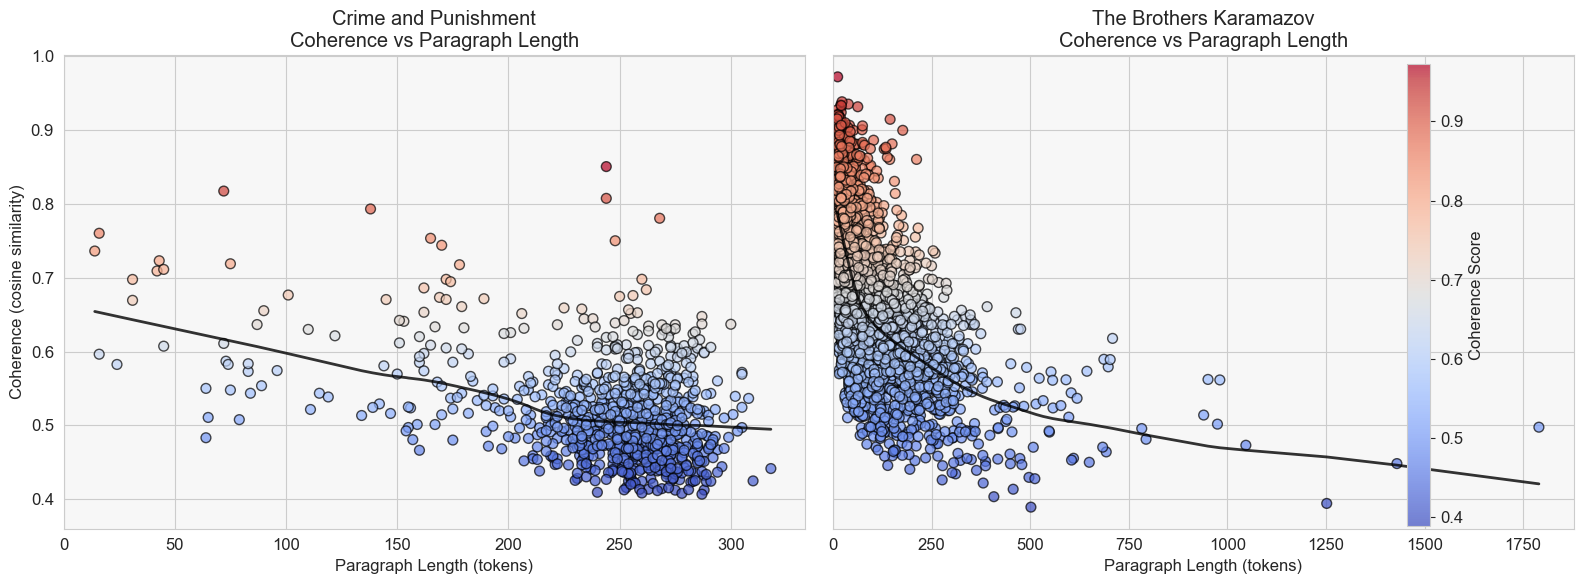

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set modern style
sns.set_style("whitegrid")
plt.rcParams.update({
    "font.size": 12,
    "figure.figsize": (16, 6),
    "axes.facecolor": "#f7f7f7",
})

fig, axes = plt.subplots(1, 2, sharey=True)

# Color map based on coherence values
cmap = plt.cm.coolwarm

# Plot 1: Crime and Punishment
scatter1 = axes[0].scatter(
    c_lengths, c_scores,
    c=c_scores,
    cmap=cmap,
    alpha=0.7,
    s=50,
    edgecolors="black"
)
sns.regplot(
    x=c_lengths, y=c_scores,
    ax=axes[0],
    scatter=False,
    lowess=True,
    line_kws={"color": "black", "lw": 2, "alpha": 0.8}
)
axes[0].set_title("Crime and Punishment\nCoherence vs Paragraph Length")
axes[0].set_xlabel("Paragraph Length (tokens)")
axes[0].set_ylabel("Coherence (cosine similarity)")
axes[0].set_xlim(left=0)

# Plot 2: The Brothers Karamazov
scatter2 = axes[1].scatter(
    b_lengths, b_scores,
    c=b_scores,
    cmap=cmap,
    alpha=0.7,
    s=50,
    edgecolors="black"
)
sns.regplot(
    x=b_lengths, y=b_scores,
    ax=axes[1],
    scatter=False,
    lowess=True,
    line_kws={"color": "black", "lw": 2, "alpha": 0.8}
)
axes[1].set_title("The Brothers Karamazov\nCoherence vs Paragraph Length")
axes[1].set_xlabel("Paragraph Length (tokens)")
axes[1].set_xlim(left=0)

# Shared colorbar
cbar = fig.colorbar(scatter2, ax=axes, orientation="vertical", fraction=0.02, pad=0.03)
cbar.set_label("Coherence Score")

plt.tight_layout()
plt.show()



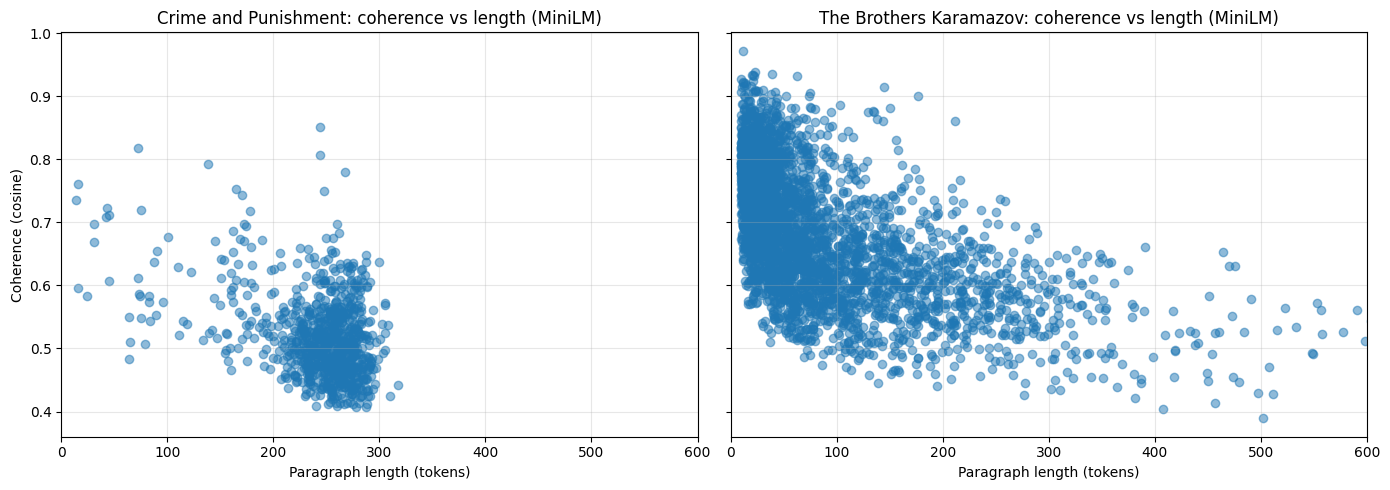

In [4]:
# Visualize coherence vs paragraph length
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

axes[0].scatter(c_lengths, c_scores, alpha=0.5)
axes[0].set_title("Crime and Punishment: coherence vs length (MiniLM)")
axes[0].set_xlabel("Paragraph length (tokens)")
axes[0].set_ylabel("Coherence (cosine)")
axes[0].set_xlim(0, 600)
axes[0].grid(True, alpha=0.3)

axes[1].scatter(b_lengths, b_scores, alpha=0.5)
axes[1].set_title("The Brothers Karamazov: coherence vs length (MiniLM)")
axes[1].set_xlabel("Paragraph length (tokens)")
axes[1].set_xlim(0, 600)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


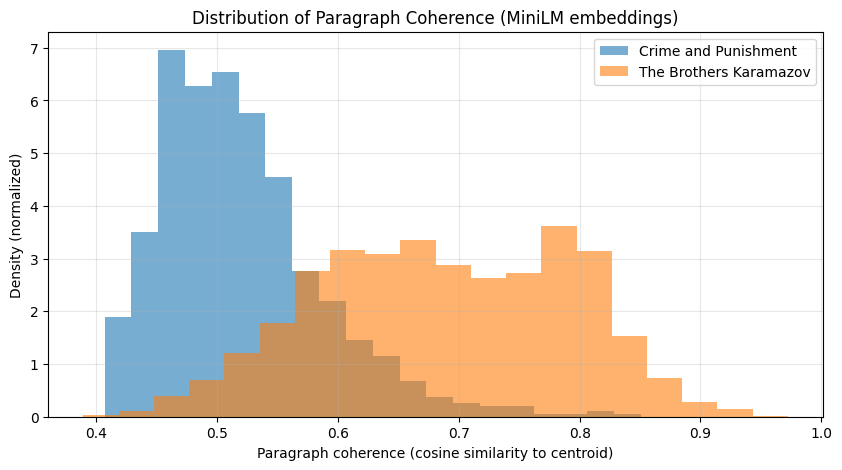

In [5]:
# Compare distributions with histograms
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(c_scores, bins=20, alpha=0.6, label='Crime and Punishment', density=True)
ax.hist(b_scores, bins=20, alpha=0.6, label='The Brothers Karamazov', density=True)
ax.set_xlabel('Paragraph coherence (cosine similarity to centroid)')
ax.set_ylabel('Density (normalized)')
ax.set_title('Distribution of Paragraph Coherence (MiniLM embeddings)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()


In [35]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from character_library import CHARACTERS
import re


In [41]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
def character_embedding(character_name: str) -> np.ndarray:
    """Get the embedding for a character's description."""
    description = CHARACTERS.get(character_name, "A fictional character.")
    emb = model.encode([description])[0]
    return emb

In [42]:
def paragraph_coherence(paragraph, model):
    sentences = re.split(r'(?<=[.!?])\s+', paragraph.strip())
    if len(sentences) < 2:
        return None  # too short to compute coherence
    embeddings = model.encode(sentences)
    centroid = np.mean(embeddings, axis=0)
    similarities = cosine_similarity([centroid], embeddings)[0]
    return np.mean(similarities)
def paragraph_coherence_embeddings(paragraphs: List[str]) -> Tuple[list, list]:
    """Compute embedding-based coherence for each paragraph.

    Steps:
    - Split each paragraph into sentences
    - Compute MiniLM embeddings for all sentences
    - Compute the centroid (mean embedding) for the paragraph
    - Coherence = average cosine similarity of each sentence
      to the centroid embedding
    """
    scores = []
    lengths = []
    for p in paragraphs:
        sents = sentence_split(p)
        if len(sents) < 2:
            continue
        # Encode all sentences in this paragraph
        sent_embs = model.encode(sents)
        centroid = sent_embs.mean(axis=0)
        sims = [cosine_similarity(e, centroid) for e in sent_embs]
        scores.append(sum(sims) / len(sims))
        lengths.append(len(" ".join(sents).split()))
    return scores, lengths

In [43]:
def extract_character_paragraphs(text, character_dict):
    character_paragraphs = {char: [] for char in character_dict}

    paragraphs = text.split('\n\n')  # or your paragraph tokenizer
    for para in paragraphs:
        para_lower = para.lower()
        for char, aliases in character_dict.items():
            if any(alias in para_lower for alias in aliases):
                character_paragraphs[char].append(para)
                break  # avoid double-counting same paragraph for multiple characters

    return character_paragraphs


In [45]:
def compute_character_coherence(character_paragraphs, model):
    coherence_scores = {}
    for char, paras in character_paragraphs.items():
        scores = [paragraph_coherence(p, model) for p in paras]
        scores = [s for s in scores if s is not None]
        if scores:
            coherence_scores[char] = {
                'mean': np.mean(scores),
                'count': len(scores),
                'all_scores': scores
            }
    return coherence_scores
#character_paragraphs = extract_character_paragraphs(crime_text, CHARACTERS)
#character_coherence = compute_character_coherence(character_paragraphs, model)

In [12]:
# Load text
with open("../data/Crime-punishment.txt", "r", encoding="utf-8") as f:
    text = f.read()

# Get characters
characters = CHARACTERS["crime_and_punishment"]

# Extract and analyze
char_paragraphs = extract_character_paragraphs(text, characters)
char_coherence = compute_character_coherence(char_paragraphs, model)

# Print results
for char, stats in char_coherence.items():
    print(f"{char}: mean={stats['mean']:.3f} from {stats['count']} paragraphs")


Raskolnikov: mean=0.529 from 506 paragraphs
Sonia: mean=0.546 from 75 paragraphs
Marmeladov: mean=0.521 from 8 paragraphs
Katerina: mean=0.552 from 16 paragraphs
Dounia: mean=0.522 from 58 paragraphs
Razumihin: mean=0.524 from 28 paragraphs
Porfiry: mean=0.538 from 5 paragraphs
Luzhin: mean=0.482 from 11 paragraphs
Lizaveta: mean=0.558 from 5 paragraphs
Zossimov: mean=0.540 from 3 paragraphs


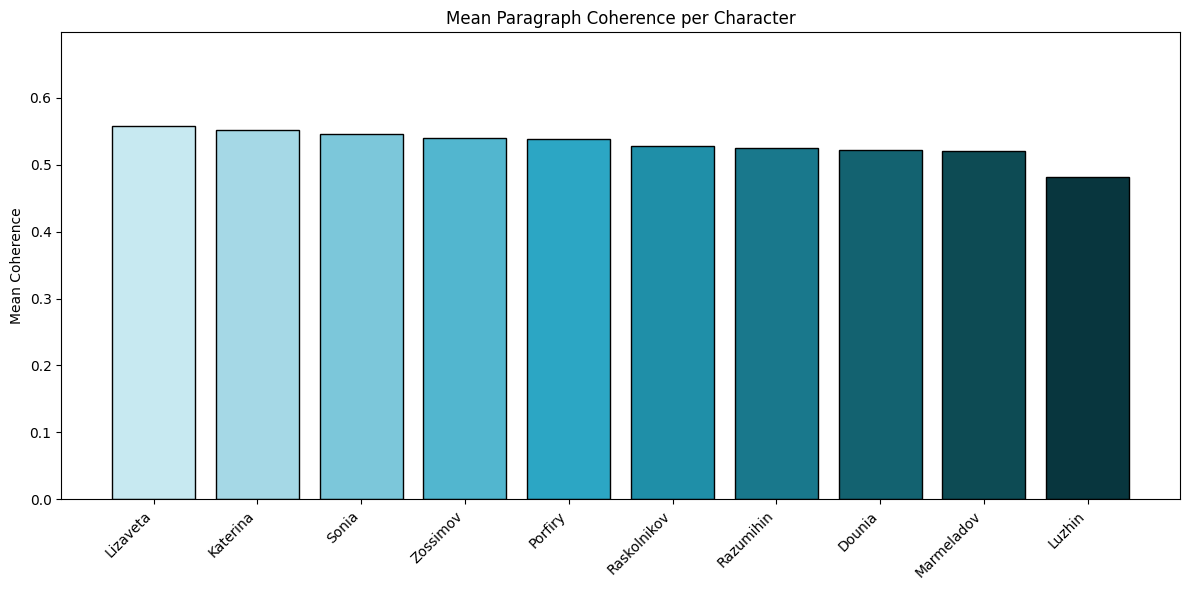

In [25]:
import matplotlib.pyplot as plt

sorted_data = sorted(char_coherence.items(), key=lambda x: x[1]['mean'], reverse=True)
chars = [item[0] for item in sorted_data]
means = [item[1]['mean'] for item in sorted_data]
plt.figure(figsize=(12, 6))
colors = [
    "#c7e9f1",  # very light aqua
    "#a5d8e6",  # soft aqua
    "#7cc7da",  # aqua teal
    "#52b6cf",  # medium teal
    "#2ca6c4",  # teal
    "#1f8fa8",  # deep teal
    "#19788c",  # dark teal-blue
    "#136270",  # deeper teal
    "#0d4b54",  # slate teal
    "#08363e"   # dark slate
]
plt.ylim(0, max(means) * 1.25)

plt.bar(chars, means, color=colors[:len(chars)], edgecolor='black', linewidth=1)
plt.xticks(rotation=45, ha='right')
plt.title("Mean Paragraph Coherence per Character")
plt.ylabel("Mean Coherence")
plt.tight_layout()
plt.show()


In [46]:
with open("../data/The-Brotherskaramazov.txt", "r", encoding="utf-8") as f:
    bk_text = f.read()
bk_characters = CHARACTERS["brothers_karamazov"]
bk_char_paragraphs = extract_character_paragraphs(bk_text, bk_characters)
bk_char_coherence = compute_character_coherence(bk_char_paragraphs, model)

for char, stats in bk_char_coherence.items():
    print(f"{char}: mean={stats['mean']:.3f} from {stats['count']} paragraphs")


Alyosha: mean=0.669 from 634 paragraphs
Ivan: mean=0.680 from 354 paragraphs
Dmitri: mean=0.689 from 559 paragraphs
Fyodor: mean=0.660 from 145 paragraphs
Grushenka: mean=0.706 from 84 paragraphs
Katerina: mean=0.702 from 5 paragraphs
Smerdyakov: mean=0.686 from 68 paragraphs
Rakitin: mean=0.679 from 40 paragraphs
Lise: mean=0.697 from 40 paragraphs
Ilusha: mean=0.707 from 62 paragraphs


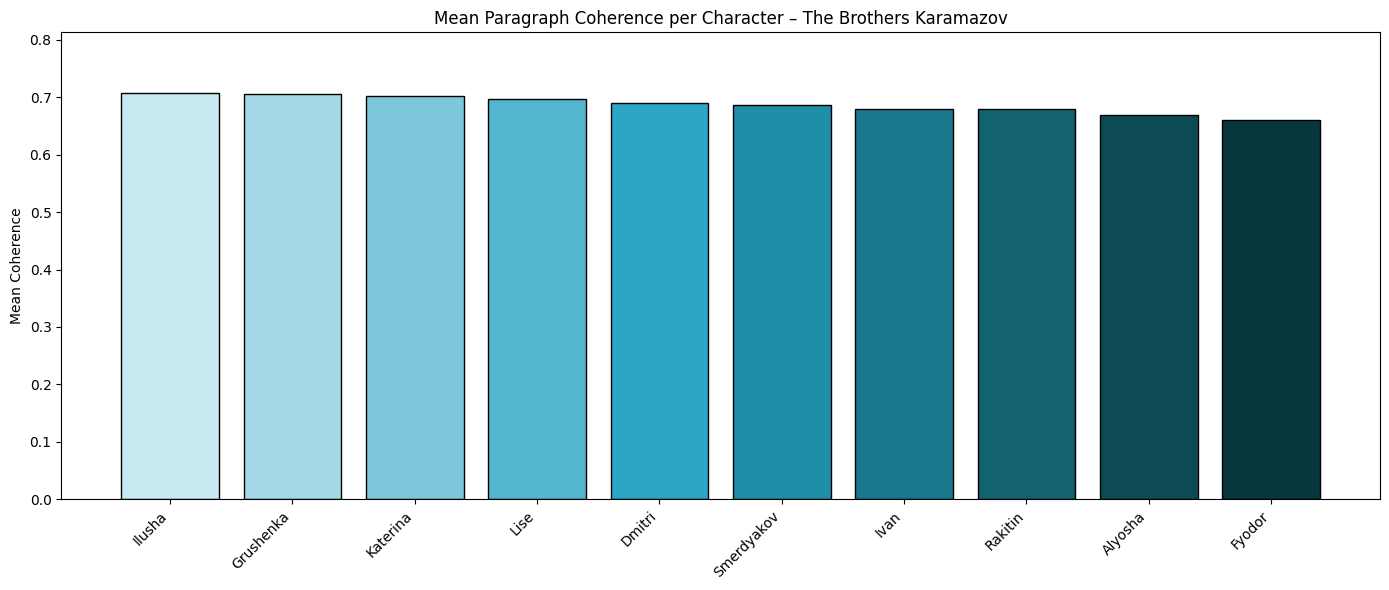

In [52]:
# Sort characters by coherence score (descending)
sorted_data = sorted(bk_char_coherence.items(), key=lambda x: x[1]['mean'], reverse=True)
chars = [item[0] for item in sorted_data]
means = [item[1]['mean'] for item in sorted_data]

plt.figure(figsize=(14, 6))

# Professional blue-green palette
colors = [
    "#c7e9f1",  # very light aqua
    "#a5d8e6",  # soft aqua
    "#7cc7da",  # aqua teal
    "#52b6cf",  # medium teal
    "#2ca6c4",  # teal
    "#1f8fa8",  # deep teal
    "#19788c",  # dark teal-blue
    "#136270",  # deeper teal
    "#0d4b54",  # slate teal
    "#08363e"   # dark slate
]

# Match color list length to number of characters
colors = (colors * (len(chars) // len(colors) + 1))[:len(chars)]

# Increase Y-axis range (more precision later)
plt.ylim(0, max(means) * 1.15)

plt.bar(chars, means, color=colors, edgecolor='black', linewidth=1)

plt.xticks(rotation=45, ha='right')
plt.title("Mean Paragraph Coherence per Character – The Brothers Karamazov")
plt.ylabel("Mean Coherence")

plt.tight_layout()
plt.show()


## Memory Cleanup

If you're running low on memory, run this cell to free up RAM by deleting large variables and clearing the model cache.

In [14]:
import gc

# Delete large variables to free memory
del crime_text, brothers_karamazov_text
del crime_paras, brothers_karamazov_paras
del c_scores, c_lengths, b_scores, b_lengths

# Clear matplotlib figures
plt.close('all')

# Unload the model from memory
del model

# Force garbage collection
gc.collect()

print("Memory cleaned! Large variables deleted and garbage collected.")

Memory cleaned! Large variables deleted and garbage collected.
